# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.metrics.pairwise import euclidean_distances

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [4]:
from sklearn.exceptions import NotFittedError

In [5]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.losses = []
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        return 1. / (1 + np.exp(-(X @ weights)))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        l2_loss = (1/(2 * self.C)) * np.sum(weights ** 2)
        pred = weights @ x.T
        loss = np.mean(np.log(1 + np.exp(-(pred * y)))) + l2_loss        
        return loss
    
    def calc_grad(self, x, weights, y):
        """Calculate the gradiend."""
        preds = 1 - (1. / (1 + np.exp(-(x @ weights) * y)))
        reg_loss = (1 / self.C) * weights
        grad = -(np.mean((y * x.T * preds), axis=1) - reg_loss)                
        return grad
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        for i in range(self.max_iter):
            last_weights = self.weights_.copy()
            delta = self.calc_grad(X_ext, self.weights_, y)            
            self.weights_ -= self.eta * delta
            loss = self.get_loss(X_ext, self.weights_, y)            
            self.losses.append(loss)            
            if np.linalg.norm(last_weights - self.weights_) < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        preds = self.predict_proba(X)
        preds = np.where(preds >= 0.5, 1, -1)        
        return preds

In [6]:
from sklearn import datasets
from sklearn import metrics

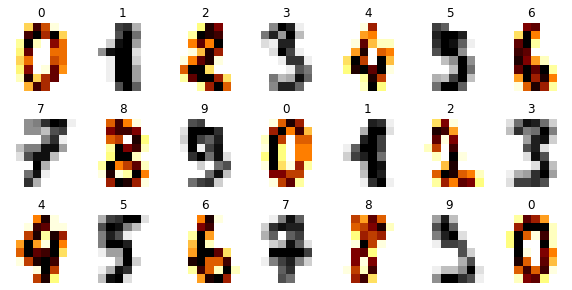

In [7]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [8]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [9]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [10]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [11]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [12]:
lr_clf.fit(X_train, y_train)

In [13]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [14]:
model_1 = CustomLogisticRegression()

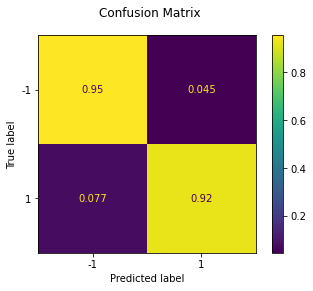

In [15]:
train_acc, test_acc = fit_evaluate(model_1, X_train, y_train, X_test, y_test)

In [16]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [17]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

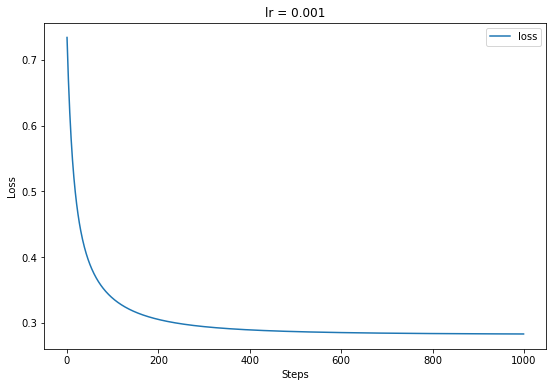

In [18]:
model_1_losses = model_1.losses
plt.figure(figsize=(9,6))
plt.plot(model_1_losses, label="loss")
plt.title(f"lr = {model_1.eta}")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend();

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

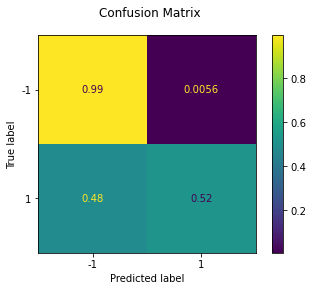

In [19]:
model_2 = CustomLogisticRegression(eta=0.01)
train_acc, test_acc = fit_evaluate(model_2, X_train, y_train, X_test, y_test)

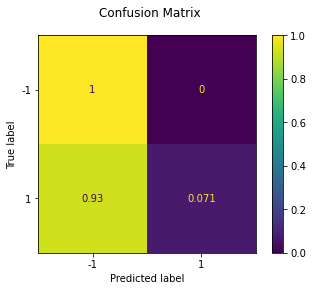

In [20]:
model_3 = CustomLogisticRegression(eta=0.1)
train_acc, test_acc = fit_evaluate(model_3, X_train, y_train, X_test, y_test)

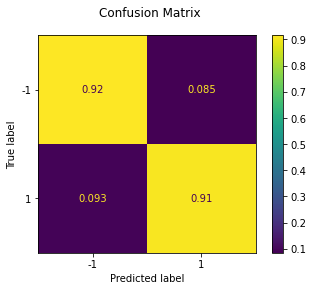

In [21]:
model_4 = CustomLogisticRegression(eta=0.0001)
train_acc, test_acc = fit_evaluate(model_4, X_train, y_train, X_test, y_test)

In [22]:
models = [model_1, model_2, model_3, model_4]

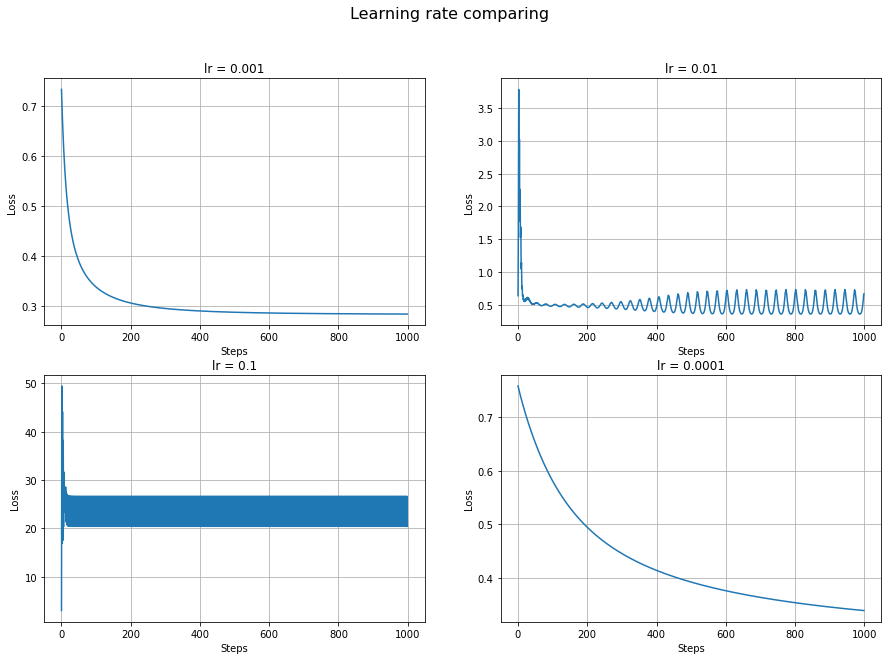

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Learning rate comparing", fontsize=16)
for i, model in enumerate(models):
    axs[i // 2][i % 2].plot(model.losses, label="loss")
    axs[i // 2][i % 2].set_xlabel("Steps")   
    axs[i // 2][i % 2].set_ylabel('Loss')  
    axs[i // 2][i % 2].set_title(f"lr = {model.eta}")    
    axs[i // 2][i % 2].grid(True)

- With high learning rate (>0.01) we have a problems with convergence, and loss is high;
- With low learning rate (0.0001) the model convergence too slow;
- Optimal LR among wich we tried, it's 0.001

**(0.5 points)** Try different regularization parameter values and compare the model quality.

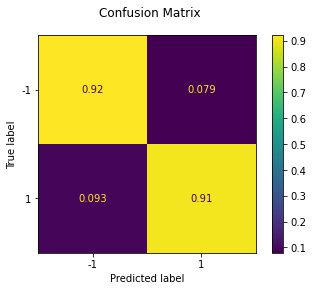

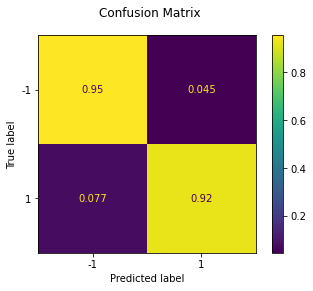

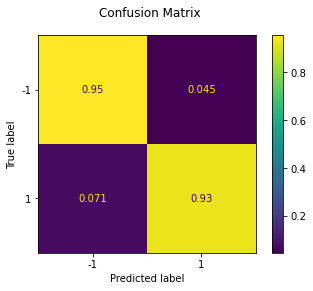

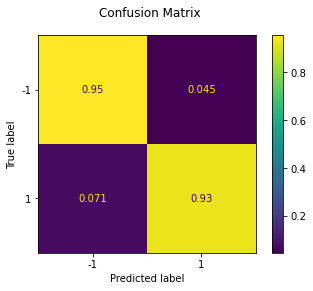

In [24]:
model_reg_1 = CustomLogisticRegression(C=0.1)
model_reg_2 = CustomLogisticRegression(C=1.0)
model_reg_3 = CustomLogisticRegression(C=10.0)
model_reg_4 = CustomLogisticRegression(C=100.0)
train_acc_1, test_acc_1 = fit_evaluate(model_reg_1, X_train, y_train, X_test, y_test)
train_acc_2, test_acc_2 = fit_evaluate(model_reg_2, X_train, y_train, X_test, y_test)
train_acc_3, test_acc_3 = fit_evaluate(model_reg_3, X_train, y_train, X_test, y_test)
train_acc_4, test_acc_4 = fit_evaluate(model_reg_4, X_train, y_train, X_test, y_test)

In [25]:
d = {"C = 0.1" : test_acc_1,
     "C = 1.0" : test_acc_2,
     "C = 10.0" : test_acc_3,
     "C = 100.0" : test_acc_4
    }
pd.DataFrame(data=d, index=["Accuracy"]).T

,Accuracy
C = 0.1,0.913889
C = 1.0,0.938889
C = 10.0,0.941667
C = 100.0,0.941667


We improve a little bit the out results with increasing the value of C

**(0.5 points)** Compare zero initialization and random initialization. 

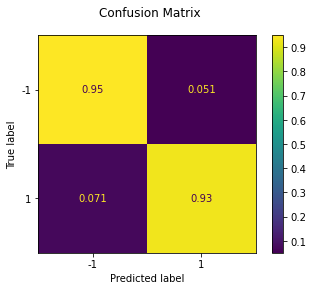

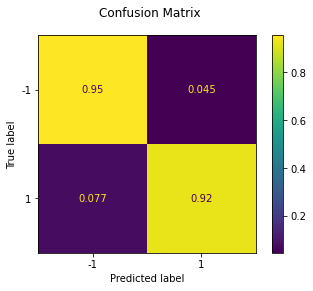

In [26]:
model_zero = CustomLogisticRegression(zero_init=True)
model_random = CustomLogisticRegression(zero_init=False)
train_acc_zero, test_acc_zero = fit_evaluate(model_zero, X_train, y_train, X_test, y_test)
train_acc_random, test_acc_random = fit_evaluate(model_random, X_train, y_train, X_test, y_test)

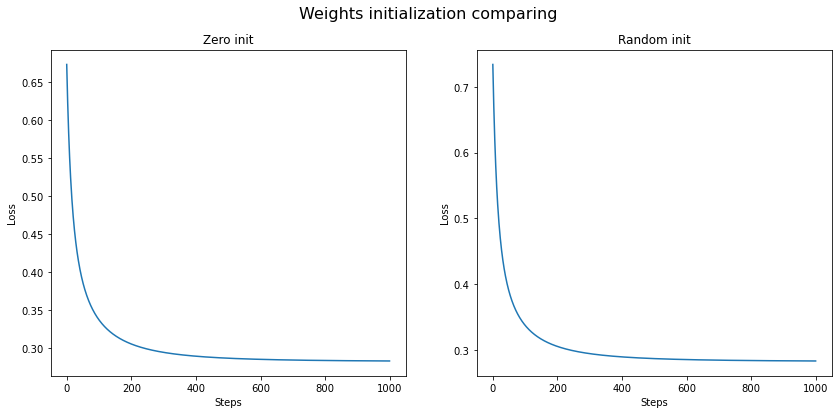

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Weights initialization comparing", fontsize=16)
ax1.plot(model_zero.losses, label="loss")
ax1.set_xlabel("Steps")   
ax1.set_ylabel('Loss')  
ax1.set_title("Zero init")    
ax2.plot(model_random.losses, label="loss")
ax2.set_xlabel("Steps")   
ax2.set_ylabel('Loss')  
ax2.set_title("Random init"); 

In [28]:
test_acc_zero, test_acc_random

(0.9388888888888889, 0.9388888888888889)

We don't get any big differences between zero and random weights initialization. Just a started error was a little smaller in zero init. But in another problem we can get a different result. 

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [29]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
        
    def euclidian_distance(self, a, b):
        return np.sqrt(np.sum((a - b)**2, axis=1))
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        distances = np.array(
            [self.euclidian_distance(x_i, Y) for x_i in X]
        )
        return distances
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        if hasattr(self, 'classes_'):
            res = np.zeros(len(model.classes_)) 
            for i, cls in enumerate(self.classes_):
                idxs = np.argwhere(y==cls)
                weight = weights[idxs].sum()
                res[i] += weight
            return res
        else:
            raise NotFittedError("KNN instance is not fitted yet")
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points /= (P + self.eps)
                
            idxs = P.argsort()
            labels = self.y[idxs]
            weights_of_points = np.take_along_axis(weights_of_points, idxs, axis=1)
            weights = np.array([])
            n = len(weights_of_points)
            for i in range(n):
                weights = np.append(weights, 
                                    (self.get_class_weights(labels[i][:self.n_neighbors], 
                                                            weights_of_points[i][:self.n_neighbors]))
                                   )
            weights = weights.reshape(n, -1)
            means = weights.sum(axis=1)
            probs = weights / means[:, np.newaxis]
            return probs
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        proba = self.predict_proba(X)
        labels = np.argmax(proba, axis=1)
        y_pred = np.take(self.classes_, labels)
        return y_pred

In [30]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [31]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [32]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

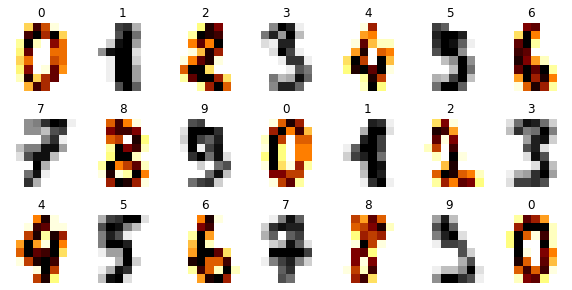

In [33]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [34]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [35]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

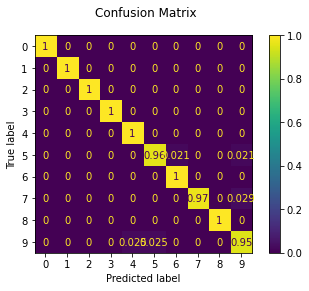

In [36]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [37]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

<b>The model confuses on numbers such as 5, 7, 9. It confuses 5 with 6 and 9; 7 with 9; 9 with 4,5. It happens because of similarity of this digits </b>

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

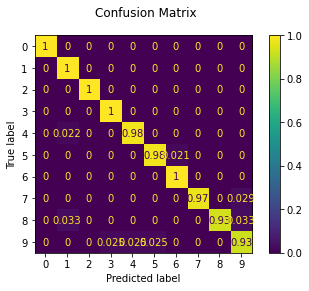

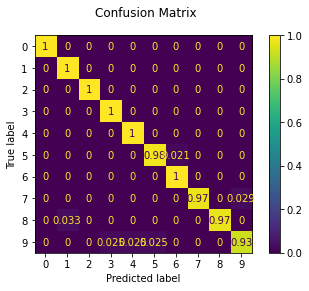

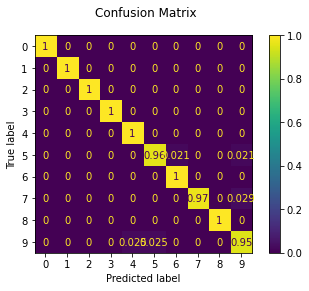

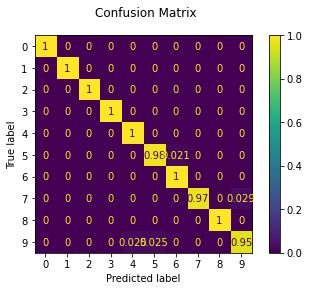

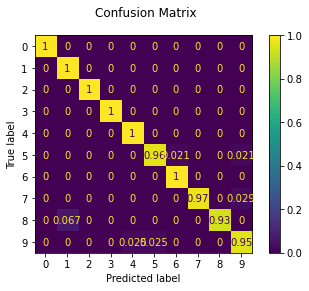

In [38]:
n_neighb = [1, 3, 5, 7, 9]
d = {}
for n in n_neighb:
    model = CustomKNeighborsClassifier(n_neighbors=n, weights='distance')
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
    d[f"{n} neighbours"] = test_acc

In [39]:
pd.DataFrame(d, index=["Test_accuracy"]).T

,Test_accuracy
1 neighbours,0.977778
3 neighbours,0.983333
5 neighbours,0.986111
7 neighbours,0.988889
9 neighbours,0.980556


We have the best test_accuracy with parameter n-neighbours = 7

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

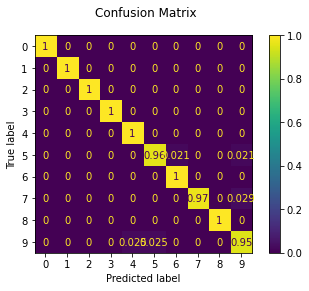

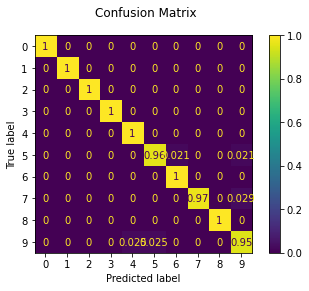

In [40]:
model_dist = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
train_acc_dist, test_acc_dist = fit_evaluate(model_dist, X_train, y_train, X_test, y_test)
model_uni = CustomKNeighborsClassifier(n_neighbors=5, weights='uniform')
train_acc_uni, test_acc_uni = fit_evaluate(model_uni, X_train, y_train, X_test, y_test)

In [41]:
d = {"Uniform_test" : test_acc_uni,
    "Uniform_train" : train_acc_uni,
    "Distance_test": test_acc_dist,
    "Distance_train": train_acc_dist}

In [42]:
pd.DataFrame(d, index=["Test_accuracy"]).T

,Test_accuracy
Uniform_test,0.986111
Uniform_train,0.989562
Distance_test,0.986111
Distance_train,1.000000


We don't get any big difference. Because all types of weights allows us to get a good results.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

We can try another distances measurment such as Minkowski distance, Manhattan metric. It possible can improves our results. But we already have not bad classifier. To classify pictures is better to use Convolutial Neural Networks

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

For example we can solve a credit scoring task with KNN and Manhattan metric. Because it's not very difficult problem and there are not too much features. And our KNN can be good and fast in this task.

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [43]:
PATH = "./data/"

In [44]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [45]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [46]:
data["Sex"].value_counts()

male      56114
female    43886
Name: Sex, dtype: int64

Let's plot gender count

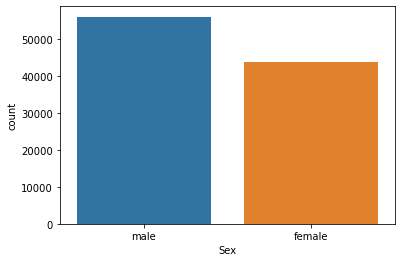

In [47]:
sns.countplot(x=data["Sex"]);

Plot the target column

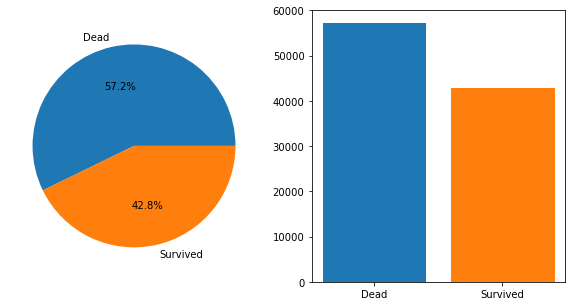

In [48]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.pie(
        data["Survived"].value_counts(normalize=True),
        labels=['Dead', 'Survived'],
        autopct='%1.1f%%'
    );

bars = ax2.bar(['Dead', 'Survived'], data["Survived"].value_counts())
bars[1].set_color('C1')

Relationships between male and female to survive

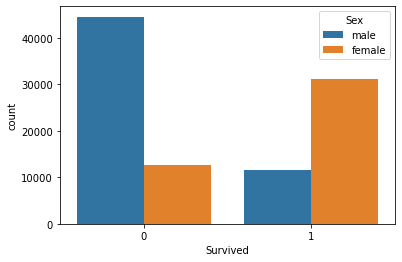

In [49]:
sns.countplot(x="Survived", hue="Sex", data=data);

A womans will stay alive with larger probability

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

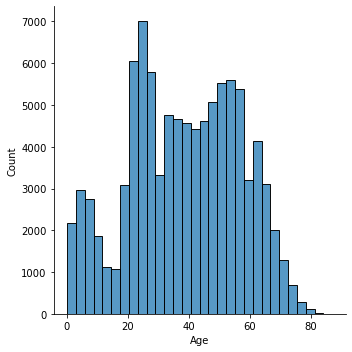

In [50]:
sns.displot(data["Age"], bins=30);

In [51]:
data["Age"].describe()

count    96708.000000
mean        38.355472
std         18.313556
min          0.080000
25%         25.000000
50%         39.000000
75%         53.000000
max         87.000000
Name: Age, dtype: float64

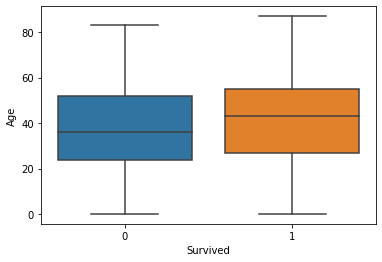

In [52]:
sns.boxplot(x="Survived", y="Age", data=data);

Median value a little larger among survived people

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

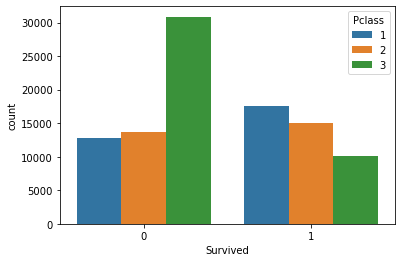

In [53]:
sns.countplot(x="Survived", hue="Pclass", data=data);

Passengers of the 1st class had a bigger chances to survive

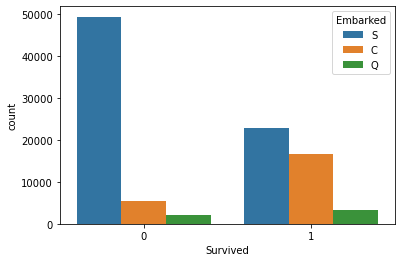

In [54]:
sns.countplot(x="Survived", hue="Embarked", data=data);

Passangers in C and Q ports had more chances to survive

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

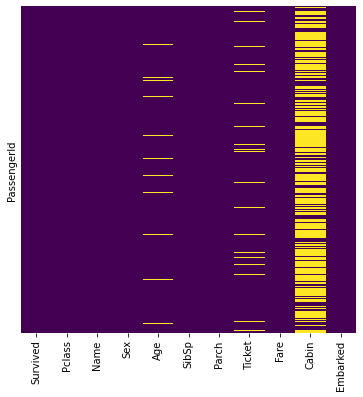

In [55]:
#plot graphicaly missing values
plt.figure(figsize=(6,6))
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap="viridis");

In [56]:
#percentage
data.isna().sum() / len(data) * 100

Survived     0.000
Pclass       0.000
Name         0.000
Sex          0.000
Age          3.292
SibSp        0.000
Parch        0.000
Ticket       4.623
Fare         0.134
Cabin       67.866
Embarked     0.250
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

We can imput values by mean in Age and Fare columns.
Cabin has too much missing values, maybe better to make a column "Cabin_known" = {0,1}

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [57]:
data.duplicated().sum()

0

In [58]:
X = data.drop(columns=["Survived", "Name", "Ticket"]) #drop Name, Ticket
y = data.Survived

Make some feature preprocessing (fill NA values)

In [59]:
X["Cabin_known"] = X['Cabin'].where(X['Cabin'].isna(), 1)
X["Cabin_known"] = X["Cabin_known"].fillna(0)
X.drop(columns=["Cabin"], inplace=True)
X["Age"].fillna(X["Age"].median(), inplace=True)
X["Fare"].fillna(X["Fare"].median(), inplace=True)
X["Embarked"].fillna(X["Embarked"].mode()[0], inplace=True)

In [60]:
#make a lists with numerical and cathegorical features
num_cols = ["Age", "SibSp", "Parch", "Fare"]
cat_cols = ["Pclass", "Sex", "Cabin_known", "Embarked"]

In [61]:
X.isna().sum()

Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Cabin_known    0
dtype: int64

In [62]:
#pipeline with standard scaler and one hot encoder
def make_pipepline(model):    
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_cols),
            ('cat', OneHotEncoder(), cat_cols)])
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    return pipe

In [63]:
log_clf = make_pipepline(LogisticRegression(random_state=42))
knn_clf = make_pipepline(KNeighborsClassifier())

In [64]:
cross_validate(log_clf, X, y, cv=5, scoring='accuracy')

{'fit_time': array([0.50979924, 0.56623363, 0.80544138, 0.58032489, 0.56748199]),
 'score_time': array([0.08005643, 0.15310168, 0.05751252, 0.06049299, 0.04587793]),
 'test_score': array([0.76815, 0.7647 , 0.768  , 0.76585, 0.7643 ])}

In [65]:
cross_validate(knn_clf, X, y, cv=5, scoring='accuracy')

{'fit_time': array([1.5054276 , 1.35853362, 1.27963018, 0.96967268, 1.02084565]),
 'score_time': array([7.00023794, 6.32621861, 7.25471091, 6.04918885, 6.21623683]),
 'test_score': array([0.74545, 0.74225, 0.74115, 0.7396 , 0.7442 ])}

We get the best test_score with LogRegression model (0.768). And with KNN the highest is 0.74545. Let's work more with LogRegression

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [66]:
#Reading our data
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
X_train = data.drop(columns = ["Survived"])
y_train = data.Survived
X_test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

There were many different researches here, but for easy to check this task, i compose all in one function

In [67]:
#Score: 0.80201
def preprocess(X_train, X_test):
    X_train_new = X_train.copy()
    X_test_new = X_test.copy()
    datasets = [X_train_new, X_test_new]
    
    for df in datasets:
        
        #extrack letters from ticket
        df['Ticket'] = df.Ticket.str.replace('\.','', regex=True).\
        str.replace('(\d+)', '', regex=True).\
        str.replace(' ', '', regex=True).\
        replace(r'^\s*$', 'X', regex=True).\
        fillna('X')

        #sex to 0, 1
        df['Sex'] = df['Sex'].map({'female': 1, 'male': 0})
        
        #sibsp and parch processing
        df["Family"] = df["SibSp"] + df["Parch"]
        df.loc[df['Family'] > 0, 'Not_alone'] = 0
        df.loc[df['Family'] == 0, 'Not_alone'] = 1
        df['Not_alone'] = df['Not_alone'].astype(int)
        df.drop(["SibSp", "Parch", "Family"], axis=1, inplace=True)
        
        #cabin process
        df["Deck"] = df["Cabin"].str[0:1]
        deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "T": 8}
        df['Deck'] = df['Deck'].map(deck)
        df['Deck'] = df['Deck'].fillna(0)
        df['Deck'] = df['Deck'].astype(int)
        df.drop(["Cabin"], axis=1, inplace=True)
        
        #fill age by median
        df["Age"].fillna(df["Age"].median(), inplace=True)
        df['Age'] = df['Age'].astype(int)
        
        #fill fare by median
        df["Fare"].fillna(df["Fare"].median(), inplace=True)        
        
        #fill embarked by mode        
        df["Embarked"].fillna(df["Embarked"].mode()[0], inplace=True)
        embarked = {"S": 0, "C": 1, "Q": 2}
        df['Embarked'] = df['Embarked'].map(embarked)
        
        #creating age category
        df['Age'] = df['Age'].astype(int)
        df.loc[ df['Age'] <= 11, 'Age'] = 0
        df.loc[(df['Age'] > 11) & (df['Age'] <= 18), 'Age'] = 1
        df.loc[(df['Age'] > 18) & (df['Age'] <= 22), 'Age'] = 2
        df.loc[(df['Age'] > 22) & (df['Age'] <= 27), 'Age'] = 3
        df.loc[(df['Age'] > 27) & (df['Age'] <= 33), 'Age'] = 4
        df.loc[(df['Age'] > 33) & (df['Age'] <= 40), 'Age'] = 5
        df.loc[(df['Age'] > 40) & (df['Age'] <= 66), 'Age'] = 6
        df.loc[ df['Age'] > 66, 'Age'] = 6  
                
        #creating fare category
        df.loc[ df['Fare'] <= 7.91, 'Fare'] = 0
        df.loc[(df['Fare'] > 7.91) & (df['Fare'] <= 14.454), 'Fare'] = 1
        df.loc[(df['Fare'] > 14.454) & (df['Fare'] <= 31), 'Fare']   = 2
        df.loc[(df['Fare'] > 31) & (df['Fare'] <= 99), 'Fare']   = 3
        df.loc[(df['Fare'] > 99) & (df['Fare'] <= 250), 'Fare']   = 4
        df.loc[ df['Fare'] > 250, 'Fare'] = 5
        df['Fare'] = df['Fare'].astype(int)      
        
        #creating age_class_category
        df['Age_Class']= df['Age']* df['Pclass']     
        
        #drop useless
        df.drop(columns=["Name"], inplace=True)
        
    return X_train_new, X_test_new

In [68]:
X_train_new, X_test_new = preprocess(X_train, X_test)

In [69]:
X_train_new.head()

,Pclass,Sex,Age,Ticket,Fare,Embarked,Not_alone,Deck,Age_Class
PassengerId,,,,,,,,,
0,1,0,5,X,2,0,0,3,5
1,3,0,5,X,1,0,1,0,15
2,3,0,0,CA,3,0,0,0,0
3,3,0,2,A,1,0,1,0,6
4,3,0,3,X,0,0,1,0,9


In [70]:
num_cols = ["Pclass", "Sex", "Age", "Fare", "Embarked", "Not_alone", "Deck", "Age_Class"]
cat_cols = ["Ticket"]

In [71]:
def make_pipepline(model):    
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_cols),
            ('cat', OneHotEncoder(), cat_cols)])
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    return pipe

In [72]:
log_clf = make_pipepline(LogisticRegression(max_iter=300,random_state=42))
grid = {"classifier__C": [0.01, 0.008, 0.001, 0.0008, 0.0006]}
gsc = GridSearchCV(log_clf, grid, cv=5, scoring='accuracy', refit=True)
gsc.fit(X_train_new, y_train);
gsc.best_score_, gsc.best_params_

(0.766, {'classifier__C': 0.01})

In [73]:
#make prediction
best_model = gsc.best_estimator_
preds = best_model.predict(X_test_new)
sample = pd.read_csv(os.path.join(PATH, 'titanic', 'sample_submission.csv')).set_index('PassengerId')
sample["Survived"] = preds
sample.reset_index(inplace=True)
sample.to_csv('./my_submission.csv', index=False)

We get the accuracy public <b>Score: 0.80201</b>

![Results](https://downloader.disk.yandex.ru/preview/b918f1ef01ae6088840044d9cc3afa5f388a167a3b524998d38ca89a41137c73/6248a4a8/Ur_93iV3oWMoAN4RLFkwrazSkGDmeCoJ3c28Y6WQR5NLPehp6jlOnIPnEtzUhSDn8Zsyh_1A-jC8_BP1n9S6KQ%3D%3D?uid=0&filename=2022-04-02_18-31-12.png&disposition=inline&hash=&limit=0&content_type=image%2Fpng&owner_uid=0&tknv=v2&size=1920x920)